# How to write a Convolution Neural Network using Google Tensorflow

# - Jamil G

### NOTE: Convolutional Neural Networks are extreamly similar to Neural Networks: they are made up of neurons (or tensors) that have learnable weights and biases. However this neural network assumes that input in an image. the Convolutional Layer is a three dimensional neuron that is used to help break apart the image into data (The MNIST dataset comprises 60,000 training examples and 10,000 test examples of the handwritten digits 0–9, formatted as 28x28-pixel monochrome images.)

##### [This tutorial is assuming you have correctly installed Tensorflow]

### First Import the following
    

In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from random import randint


### Our CNN will be in the following layout
<p>
<ol>
<li>
Convolutional Layer #1: Applies 32 5x5 filters (extracting 5x5-pixel subregions), with ReLU activation function
    conv2d(): Constructs a two-dimensional convolutional layer. Takes number of filters, filter kernel size, padding, and activation function as arguments.
</li>
<li>
Pooling Layer #1: Performs max pooling with a 2x2 filter and stride of 2 (which specifies that pooled regions do not overlap)
    max_pooling2d(): Constructs a two-dimensional pooling layer using the max-pooling algorithm. Takes pooling filter size and stride as arguments.
</li>
<li>
Convolutional Layer #2: Applies 64 5x5 filters, with ReLU activation function
</li>
<li>
Pooling Layer #2: Again, performs max pooling with a 2x2 filter and stride of 2
</li>
<li>
Dense Layer #1: 1,024 neurons, with dropout regularization rate of 0.4 (probability of 0.4 that any given element will be dropped during training)
    dense(): Constructs a dense layer. Takes number of neurons and activation function as arguments.
</li>
<li>
Dense Layer #2 (Logits Layer): 10 neurons, one for each digit target class (0–9).
</li>
</ol>
</p>

In [2]:
def cnn_model_fn(features, labels, mode):
  #
  # Our input layer is an image that looks as such
  # [batch_size, image_width, image_height, channels],
  # batch_size = how many images we are working with (-1 if you dont know the size)
  # image_width = width of the image
  # image_height = height of the image
  # channels = number of color channels (since its a monochrome image it is only looking for black)
  # for color images the channels can be 3 (red, green , blue)

  # Input Layer
  input_layer = tf.reshape(features["x"], [-1, 28, 28, 1])

  # in this first layer we will have 32 5 by 5 (800 filters)
  # the activation function will be a RELU function
  # the Padding argument determins what the output should look like (in our case the input and output should be the same)
  # Convolutional Layer #1
  conv1 = tf.layers.conv2d(
      inputs=input_layer,
      filters=32,
      kernel_size=[5, 5],
      padding="same",
      activation=tf.nn.relu)
  
  
  # now we add the pooling layer
  # pool size represents the pooling filters [width,height]
  # strides represents the size of the stride
  #
  # Pooling Layer #1
  pool1 = tf.layers.max_pooling2d(inputs=conv1, pool_size=[2, 2], strides=2)

  # Convolutional Layer #2 and Pooling Layer #2
  conv2 = tf.layers.conv2d(
      inputs=pool1,
      filters=64,
      kernel_size=[5, 5],
      padding="same",
      activation=tf.nn.relu)
  pool2 = tf.layers.max_pooling2d(inputs=conv2, pool_size=[2, 2], strides=2)
  
  
  # to preform classifications we are adding a dense layer (1024 neurons and RELu activation)
  # but we need to flatten the inputs (to recreate the image)
  pool2_flat = tf.reshape(pool2, [-1, 7 * 7 * 64])
    
  # 1,024 neurons, with dropout regularization rate of 0.4 (probability of 0.4 
  # that any given element will be dropped during training)
  dense = tf.layers.dense(inputs=pool2_flat, units=1024, activation=tf.nn.relu)
  dropout = tf.layers.dropout(
      inputs=dense, rate=0.4, training=mode == tf.estimator.ModeKeys.TRAIN)

  # Logits Layer
  # 10 neurons, one for each digit target class (0–9).
  logits = tf.layers.dense(inputs=dropout, units=10)

  predictions = {
      # Generate predictions (for PREDICT and EVAL mode)
      # For a given example, our predicted class is the element in the corresponding 
      # row of the logits tensor with the highest raw value. We can 
      # find the index of this element using the tf.argmax function:
      "classes": tf.argmax(input=logits, axis=1),
      # Add `softmax_tensor` to the graph. It is used for PREDICT and by the
      # `logging_hook`.
      # this will show us the probilitiy of the image to be a specific number
      "probabilities": tf.nn.softmax(logits, name="softmax_tensor")
  }

  if mode == tf.estimator.ModeKeys.PREDICT:
    return tf.estimator.EstimatorSpec(mode=mode, predictions=predictions)

  # Calculate Loss (for both TRAIN and EVAL modes)
  onehot_labels = tf.one_hot(indices=tf.cast(labels, tf.int32), depth=10)
  loss = tf.losses.softmax_cross_entropy(
      onehot_labels=onehot_labels, logits=logits)

  # Configure the Training Op (for TRAIN mode)
  if mode == tf.estimator.ModeKeys.TRAIN:
    optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.001)
    train_op = optimizer.minimize(
        loss=loss,
        global_step=tf.train.get_global_step())
    return tf.estimator.EstimatorSpec(mode=mode, loss=loss, train_op=train_op)

  # Add evaluation metrics (for EVAL mode)
  eval_metric_ops = {
      "accuracy": tf.metrics.accuracy(
          labels=labels, predictions=predictions["classes"])}
  return tf.estimator.EstimatorSpec(
      mode=mode, loss=loss, eval_metric_ops=eval_metric_ops)

In [3]:
# Load training and eval data
mnist = tf.contrib.learn.datasets.load_dataset("mnist")
train_data = mnist.train.images  # Returns np.array
train_labels = np.asarray(mnist.train.labels, dtype=np.int32)
eval_data = mnist.test.images  # Returns np.array
eval_labels = np.asarray(mnist.test.labels, dtype=np.int32)

Extracting MNIST-data\train-images-idx3-ubyte.gz
Extracting MNIST-data\train-labels-idx1-ubyte.gz
Extracting MNIST-data\t10k-images-idx3-ubyte.gz
Extracting MNIST-data\t10k-labels-idx1-ubyte.gz


In [4]:
# Create the Estimator
# Next, let's create an Estimator (a TensorFlow class for performing high-level 
# model training, evaluation, and inference) for our model. Add the following code to 
mnist_classifier = tf.estimator.Estimator(
    model_fn=cnn_model_fn, model_dir="C:/Users/JamilG-Lenovo/Desktop/Code/Python/TensorFlow/CNN MNIST/mnist_convnet_model")


INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': 'C:/Users/JamilG-Lenovo/Desktop/Code/Python/TensorFlow/CNN MNIST/mnist_convnet_model', '_tf_random_seed': 1, '_save_summary_steps': 100, '_save_checkpoints_secs': 600, '_save_checkpoints_steps': None, '_session_config': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100}


In [5]:
# Set up logging for predictions
# Log the values in the "Softmax" tensor with label "probabilities"
tensors_to_log = {"probabilities": "softmax_tensor"}
logging_hook = tf.train.LoggingTensorHook(
    tensors=tensors_to_log, every_n_iter=50)

In [6]:
 # Train the model
train_input_fn = tf.estimator.inputs.numpy_input_fn(
      x={"x": train_data},
      y=train_labels,
      batch_size=100,
      num_epochs=None,
      shuffle=True)

In [7]:
  
mnist_classifier.train(
      input_fn=train_input_fn,
      steps=20,
      hooks=[logging_hook])


INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from C:/Users/JamilG-Lenovo/Desktop/Code/Python/TensorFlow/CNN MNIST/mnist_convnet_model\model.ckpt-2760
INFO:tensorflow:Saving checkpoints for 2761 into C:/Users/JamilG-Lenovo/Desktop/Code/Python/TensorFlow/CNN MNIST/mnist_convnet_model\model.ckpt.
INFO:tensorflow:probabilities = [[ 0.00352161  0.00000128  0.06218408  0.00245948  0.00441723  0.00063659
   0.90897059  0.01582474  0.00178042  0.00020396]
 [ 0.00649854  0.00004906  0.00003404  0.06764243  0.00714354  0.86202097
   0.00543355  0.00003497  0.04397628  0.00716654]
 [ 0.00029208  0.00000566  0.00308422  0.00023561  0.91533256  0.00262638
   0.04322397  0.00009438  0.00341631  0.03168885]
 [ 0.00020963  0.00122474  0.01705637  0.91199923  0.00006107  0.01483131
   0.00026245  0.00029632  0.05361235  0.00044643]
 [ 0.00029202  0.93499959  0.01627621  0.00671535  0.00179467  0.00280622
   0.00315454  0.0078731   0.01756785  0.00852038]
 [ 0.0005204

INFO:tensorflow:loss = 0.372004, step = 2761
INFO:tensorflow:Saving checkpoints for 2780 into C:/Users/JamilG-Lenovo/Desktop/Code/Python/TensorFlow/CNN MNIST/mnist_convnet_model\model.ckpt.
INFO:tensorflow:Loss for final step: 0.444285.


In [8]:
# Evaluate the model and print results
eval_input_fn = tf.estimator.inputs.numpy_input_fn(
      x={"x": eval_data},
      y=eval_labels,
      num_epochs=1,
      shuffle=False)

In [9]:
eval_results = mnist_classifier.evaluate(input_fn=eval_input_fn)

INFO:tensorflow:Starting evaluation at 2017-09-19-16:17:37
INFO:tensorflow:Restoring parameters from C:/Users/JamilG-Lenovo/Desktop/Code/Python/TensorFlow/CNN MNIST/mnist_convnet_model\model.ckpt-2780
INFO:tensorflow:Finished evaluation at 2017-09-19-16:17:50
INFO:tensorflow:Saving dict for global step 2780: accuracy = 0.8919, global_step = 2780, loss = 0.417171


In [10]:
  print("\n\n\nEvaluation Results: " + str(eval_results))




Evaluation Results: {'accuracy': 0.8919, 'loss': 0.41717118, 'global_step': 2780}


In [11]:
# We are going to take the evaluated Data(pictures) and labels(number) and store them into a 
# Dictionary so we can easily access specified numbers
position = 0
dic = {}
for item in eval_labels:
    if item in dic.keys():
        photos = dic[item]
        photos.append(eval_data[position])
    else:
        photos = [eval_data[position]]
    dic[item] = photos
    position = position +1


In [12]:
# Lets create the ability to display images
# We will display a random selection of a specified number
def display_digit(num):
    print("we are looking for:" + str(num))
    label = num
    random_image = randint(0, len(dic[num]))
    print("using the " + str(random_image) + " image in the list")
    image = dic[num][0].reshape([28,28])
    plt.title('Example: %d  Label: %d' % (num, label))
    plt.imshow(image, cmap=plt.get_cmap('gray_r'))
    plt.show()

In [13]:
# Now we have a dictionary where the key represents the guessed number
# the item is a list of images
print(sorted(dic.keys()))

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]


In [14]:
# One image has 784 numbers (28 by 28)
print(str(len(dic[4][1])))

784


we are looking for:7
using the 874 image in the list


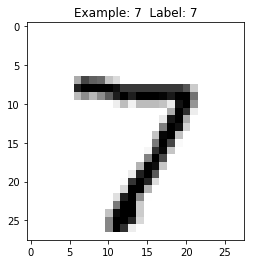

In [15]:
display_digit(7)

we are looking for:7
using the 1019 image in the list


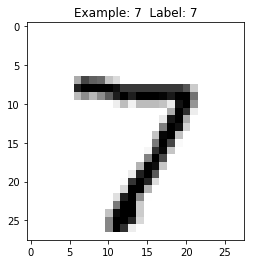

In [16]:
display_digit(7)

In [17]:
# lets see how different the two images are
print( str ( sum(dic[7][703]) - sum (dic[7][483])   ) )

-2.39607850462


### this shows that the two images are similar, but not 100% the same